In [10]:
import numpy as np
#import keras
import os
from __future__ import division, print_function, unicode_literals
import tensorflow as tf
import matplotlib.pyplot as plt

## Capsnets for SNAKE

https://www.kaggle.com/nicw102168/snake-eyes 

----

In [11]:
path = os.getcwd() +"\\snake-eyes\\snake-eyes\\"

os.listdir(path)

['snakeeyes_00.dat',
 'snakeeyes_01.dat',
 'snakeeyes_02.dat',
 'snakeeyes_03.dat',
 'snakeeyes_04.dat',
 'snakeeyes_05.dat',
 'snakeeyes_06.dat',
 'snakeeyes_07.dat',
 'snakeeyes_08.dat',
 'snakeeyes_09.dat',
 'snakeeyes_test.dat']

**File reading (thanks to nic):**

In [12]:
def read_vectors(*filenames):
    data = np.vstack(
        tuple(np.fromfile(filename, dtype=np.uint8).reshape(-1,401)
                      for filename in filenames))
                      
    return data[:,1:], np.eye(12)[data[:,0] - 1]

X_train, y_train = read_vectors(*[path+"snakeeyes_{:02d}.dat".format(nn) for nn in range(10)])
X_test, y_test = read_vectors(*[path + "snakeeyes_test.dat"])



In [4]:
print(X_train.shape)

print(X_test.shape)

(1000000, 400)
(10000, 400)


In [5]:
type(X_train[0][0])

numpy.uint8

**Let's see what an image looks like:**

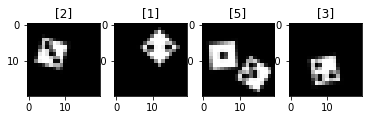

In [13]:
image = X_train[0, :]

plt.subplot(141)
plt.title('{}'.format(np.where(y_train[0]==1)[0]))
plt.imshow(image.reshape(20, 20), cmap = 'gray')
plt.subplot(142)
plt.title('{}'.format(np.where(y_train[1]==1)[0]))
plt.imshow(X_train[1, :].reshape(20, 20), cmap = 'gray')
plt.subplot(143)
plt.title('{}'.format(np.where(y_train[2]==1)[0]))
plt.imshow(X_train[2, :].reshape(20, 20), cmap = 'gray')
plt.subplot(144)
plt.title('{}'.format(np.where(y_train[9]==1)[0]))
plt.imshow(X_train[9, :].reshape(20, 20), cmap = 'gray')
plt.show()


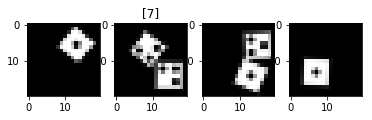

In [14]:
plt.subplot(141)
#plt.title('{}'.format(y_train[0]))
plt.imshow(X_train[4, :].reshape(20, 20), cmap = 'gray')
plt.subplot(142)
plt.title('{}'.format(np.where(y_train[8]==1)[0]))
plt.imshow(X_train[8, :].reshape(20, 20), cmap = 'gray')
plt.subplot(143)
#plt.title('{}'.format(y_train[2]))
plt.imshow(X_train[6, :].reshape(20, 20), cmap = 'gray')
plt.subplot(144)
#plt.title('{}'.format(y_train[2]))
plt.imshow(X_train[7, :].reshape(20, 20), cmap = 'gray')
plt.show()

In [16]:
res = [ np.where(r==1)[0][0] for r in y_train ]

In [17]:
X_train = X_train.reshape(1000000, 20, 20)
X_test = X_test.reshape(10000, 20, 20)
print(X_train.shape)
print(X_test.shape)

(1000000, 20, 20)
(10000, 20, 20)


**Idea: pre-apply filter to get high contrast images**

## Tensorflow Capsnet

In [18]:
tf.reset_default_graph()
np.random.seed(42)
tf.set_random_seed(42)

---

In [19]:
X = tf.placeholder(shape = [None, 20, 20, 1], dtype = tf.float32)

In [20]:
caps1_n_maps = 32
caps1_n_caps = caps1_n_maps * 6 * 6
caps1_n_dims = 8

In [21]:
conv1_params = {
    "filters": 32,
    "kernel_size": 5,
    "strides": 1, 
    "padding": "valid",
    "activation": tf.nn.relu,
}

conv2_params = { 
    "filters": 32, 
    "kernel_size": 5,
    "strides": 2,
    "padding": "valid",
    "activation": tf.nn.relu,
}

In [22]:
conv1 = tf.layers.conv2d(X, name = "conv1", **conv1_params)
conv2 = tf.layers.conv2d(conv1, name = "conv2", **conv2_params)

In [23]:
conv1.shape
print(conv2.shape)

(?, 6, 6, 32)


In [24]:
def squash(s, axis=-1, epsilon=1e-7, name=None):
    with tf.name_scope(name, default_name="squash"):
        squared_norm = tf.reduce_sum(tf.square(s), axis=axis,
                                     keep_dims=True)
        safe_norm = tf.sqrt(squared_norm + epsilon)
        squash_factor = squared_norm / (1. + squared_norm)
        unit_vector = s / safe_norm
        return squash_factor * unit_vector